In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {
    'font.size': 7,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'xtick.major.width': 0,
    'xtick.minor.width': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'ytick.major.width': 0,
    'ytick.minor.width': 0,
    'figure.figsize': (6, 4),
    "axes.grid" : True,
    "grid.color": "grey",
    "grid.linewidth": 0.3,
    "grid.linestyle": ":",
    "axes.grid.axis": "y",
    "axes.grid.which": "both",
    "axes.axisbelow": False,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.title_fontsize': 8,
    'figure.dpi': 300,  # the left side of the subplots of the figure
    'figure.subplot.left': 0.195,  # the left side of the subplots of the figure
    'figure.subplot.right': 0.97,   # the right side of the subplots of the figure
    'figure.subplot.bottom': 0.145,   # the bottom of the subplots of the figure
    'figure.subplot.top': 0.97,   # the top of the subplots of the figure
    'figure.subplot.wspace': 0.2,    # the amount of width reserved for space between subplots,
                                   # expressed as a fraction of the average axis width
    'figure.subplot.hspace': 0.2,    # the amount of height reserved for space between subplots,
                               # expressed as a fraction of the average axis height
}
mpl.rcParams.update(params)

In [2]:
def find_inverse(real, imaginary, N):

    # Form complex numbers corresponding to each frequency
    f = [complex(r, i) for r, i in zip(real, imaginary)]

    f = np.hstack([0, f])
    # Obtain time series
    return np.fft.irfft(f, n=N)

    
def scale_lc(lc, mean, rms):
    
    lc_mean = np.mean(lc)
    lc_std = np.std(lc)

    return ((lc - lc_mean) / lc_std * rms + 1) * mean

        
def timmerkoenig(pds_shape, mean, rms):
    pds_size = pds_shape.size

    real = np.random.normal(size=pds_size) * np.sqrt(0.5 * pds_shape)
    imaginary = np.random.normal(size=pds_size) * np.sqrt(0.5 * pds_shape)
    imaginary[-1] = 0

    flux = find_inverse(real, imaginary, N=2 * pds_size)

    rescaled_flux = scale_lc(flux, mean, rms)

    return rescaled_flux


Let us start with a standard light curve simulation with the [Timmer & Koenig](https://ui.adsabs.harvard.edu/abs/1995A&A...300..707T/abstract) method:

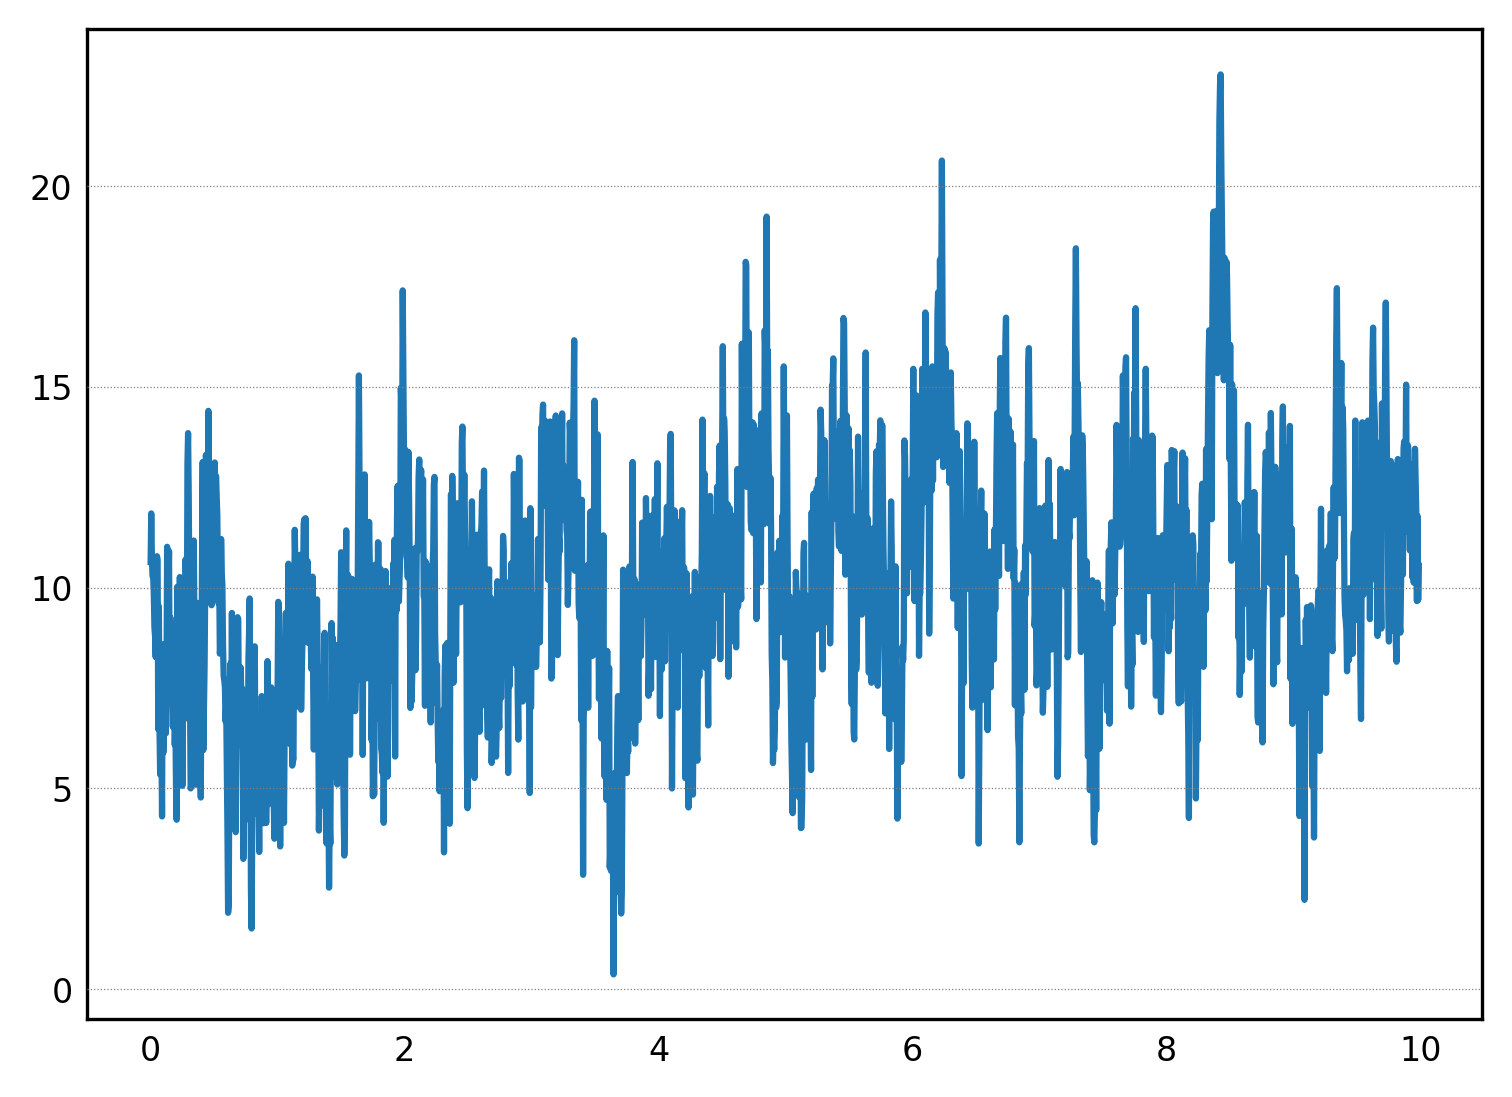

In [3]:
from astropy.modeling import models

pds_model = \
    models.PowerLaw1D(x_0=1, alpha=1, amplitude=1)

nyq = 100.
freq = np.linspace(0, nyq, 1000)[1:]

pds_shape = pds_model(freq)
mean = 10
rms = 0.3

dt = 0.5 / nyq

flux = timmerkoenig(pds_shape, mean, rms)
times = dt * np.arange(flux.size)

plt.plot(times, flux)

## Simulating event times with the inverse CDF method

Given a positive-definite light curve (generated, e.g., with the method by Timmer & Koenig), we treat it as a probability distribution: we calculate the cumulative distribution function by calculating its cumulative sum and normalizing to 1. Then, we generate random numbers uniformly distributed between 0 and 1 (horizontal lines) and take the event times at the corresponding values of the CDF (vertical lines).

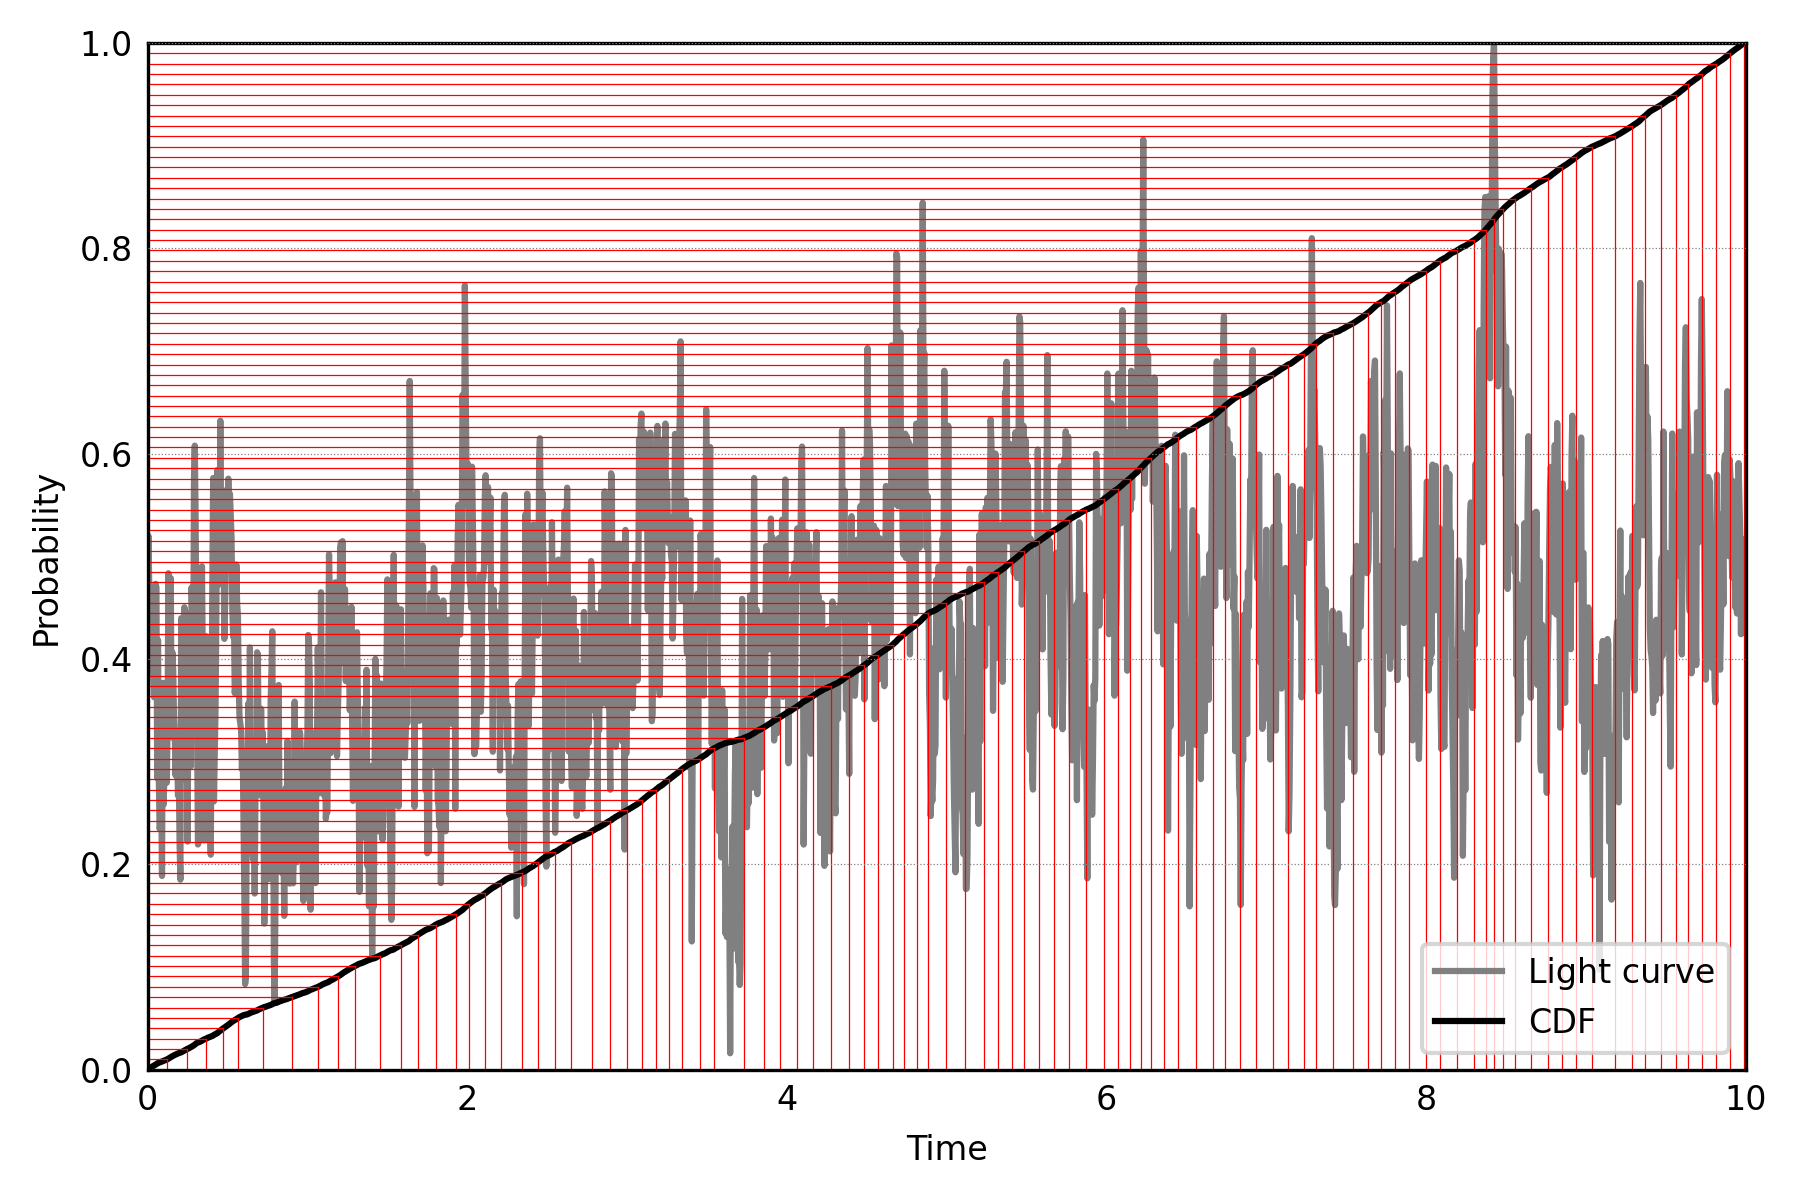

In [4]:
from scipy.interpolate import interp1d

def cdf_from_lc(lc, dt):
    cdf = np.cumsum(lc)
    cdf = np.concatenate([[0], cdf])
    cdf /= cdf.max()
    return cdf    


# cdf_times = np.concatenate([[0], dt / 2 + time])
cdf_values = cdf_from_lc(flux, dt)
cdf_times = np.arange(cdf_values.size) * dt

cdf_inverse = interp1d(cdf_values, cdf_times)

plt.plot(times, flux / flux.max(), color="grey", label="Light curve")
plt.plot(cdf_times, cdf_values, color="k", label="CDF")

for prob_val in np.linspace(0, 1, 100):
    time = cdf_inverse(prob_val)
    plt.plot([0, time], [prob_val, prob_val], color="r", lw=0.3)
    plt.plot([time, time], [0, prob_val], color="r", lw=0.3)
    
plt.xlabel("Time")
plt.ylabel("Probability")

plt.ylim([0, 1])
plt.xlim([0, 10])
plt.legend(loc="lower right");
plt.tight_layout()
plt.savefig("CDF_lc.jpg")

The same method can be used, in principle, to simulate variates from *any* probability distribution. The only requirement is that the input distribution is positive definite.
Stingray implements this method in `stingray.simulator.base`:

In [5]:
from stingray.simulator.base import simulate_with_inverse_cdf
event_times = simulate_with_inverse_cdf(flux, 10)

In [6]:
event_times

array([0.95290443, 0.92394412, 0.25721135, 0.19045643, 0.07508685,
       0.73695178, 0.23974511, 0.93515749, 0.97591308, 0.64216602])